In [1]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fooof import FOOOFGroup

C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\2397346086.py:13: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [2]:
# Load the CSV file into a DataFrame and enter some details about the subject
eeg_data = pd.read_csv(input("Enter location of csv file which includes EEG for somnotate scoring: "))

somno_scoring = pd.read_csv(input("Enter location of file of the somnotatate scoring converted back to csv: "))

# Set sampling rate, and create a times vector for plotting
fs = int(input("Sampling rate of signal in Hz: "))

#Enter details about the subject
sub = input("Enter subject ID: ")
extra_info = input("Any extra details about the recording: ")
epoch_duration = int(input("Enter length of epoch for exponent analysis in seconds: "))

In [ ]:
## Use neurodsp to determine the PSD for both channels at the epoch of interest

# Calculate total recording time in seconds and number of bins
recording_seconds = len(eeg_data) / fs  # Assuming all channels have the same length
num_bins = int(recording_seconds // epoch_duration)  # For the entirety of recording length

# Calculate number of samples per bin
samples_per_bin = fs * epoch_duration

# Prepare a dictionary to store PSD values and frequency data for each channel
psd_values_dict = {}
frequencies = None  # Frequencies are the same for each bin

# Define a small number (epsilon) to add to 0 values
epsilon = 1e-10

# Loop over each EEG channel
for channel, sig in eeg_data.items():
    # Initialize a list to store PSD values for the current channel
    psd_values_dict[channel] = []

    # Loop over each bin
    for i in range(num_bins):
        # Extract the data for the current bin
        start = i * samples_per_bin
        end = start + samples_per_bin
        bin_data = sig[start:end]
        
        # Compute the power spectrum for this bin
        freqs, psd = compute_spectrum(bin_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
        
        # Store the PSD values
        psd_values_dict[channel].append(psd)
        
        # Store frequencies once
        if frequencies is None:
            frequencies = freqs

# Convert psd_values to NumPy arrays for easier handling
for channel in psd_values_dict:
    psd_values_dict[channel] = np.array(psd_values_dict[channel])

# Get the psd values for each EEG channel
psd_values_eeg1 = psd_values_dict['EEG1']
psd_values_eeg2 = psd_values_dict['EEG2']

psd_values_eeg1[psd_values_eeg1 == 0] = epsilon
psd_values_eeg2[psd_values_eeg2 == 0] = epsilon

In [4]:
## Run the psd and frequency through fooof to fit data

# Initialize a FOOOFGroup object, specifying some parameters - eeg1
fg_eeg1 = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,
           peak_threshold=2.0, aperiodic_mode='fixed')

# Fit FOOOF model across the matrix of power spectra
fg_eeg1.fit(freqs, psd_values_eeg1, [2, 40])

# Initialize a FOOOFGroup object, specifying some parameters - eeg2
fg_eeg2 = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,
           peak_threshold=2.0, aperiodic_mode='fixed')

# Fit FOOOF model across the matrix of power spectra
fg_eeg2.fit(freqs, psd_values_eeg2, [2, 40])

Running FOOOFGroup across 25072 power spectra.
Running FOOOFGroup across 25072 power spectra.


C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\4083087617.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the figure layout, leaving space at the top for the title


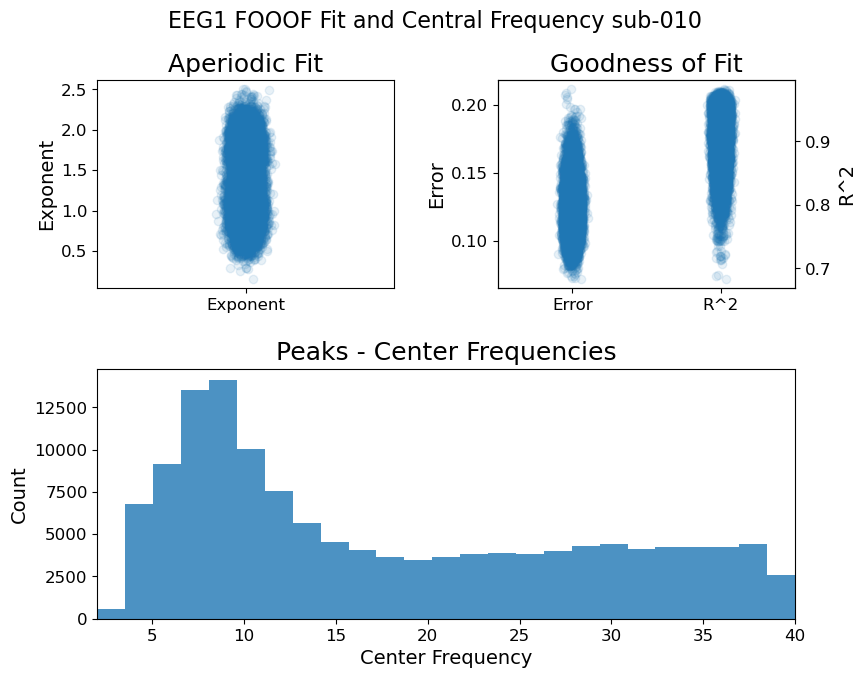

In [5]:
## Plot the model fitting and central frequency of dataset

# Plot using FOOOF
fg_eeg1.plot(
    save_fig=False,  # Don't save yet
    file_name=f'{sub}_fit_and_cf_{extra_info}_eeg1.png',
    file_path='Z:/volkan/fooof/figures/goodness_of_fit_and_cf'
)

# Get the current figure and add the title at the top
fig = plt.gcf()  # Get the current figure
fig.suptitle(f'EEG1 FOOOF Fit and Central Frequency {sub}', fontsize=16, )  # Add a title above the subplots

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the figure layout, leaving space at the top for the title

# Save the figure
plt.savefig(f'Z:/volkan/fooof/figures/goodness_of_fit_and_cf/{sub}_fit_and_cf_{extra_info}_eeg1.png')


In [ ]:
## Plot the model fitting and central frequency of dataset

# Plot using FOOOF
fg_eeg2.plot(
    save_fig=False,  # Don't save yet
    file_name=f'{sub}_fit_and_cf_{extra_info}_eeg2.png',
    file_path='Z:/volkan/fooof/figures/goodness_of_fit_and_cf'
)

# Get the current figure and add the title at the top
fig = plt.gcf()  # Get the current figure
fig.suptitle(f'EEG2 FOOOF Fit and Central Frequency {sub}', fontsize=16, )  # Add a title above the subplots

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the figure layout, leaving space at the top for the title

# Save the figure
plt.savefig(f'Z:/volkan/fooof/figures/goodness_of_fit_and_cf/{sub}_fit_and_cf_{extra_info}_eeg2.png')


In [ ]:
fg_eeg1.save_report(f'FOOOFGroup_report_{sub}_{extra_info}_eeg1.pdf', file_path='Z:/volkan/fooof/group_report')
fg_eeg2.save_report(f'FOOOFGroup_report_{sub}_{extra_info}_eeg2.pdf', file_path='Z:/volkan/fooof/group_report')

In [6]:
# Extract aperiodic parameters and then combine
exps_eeg1 = fg_eeg1.get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_eeg2.get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2 # use the average exponent across channels for future analysis

In [7]:
## Convert somno scoring into value for every second

df = somno_scoring

# Ensure the Timestamp column is in datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Define the expected range of timestamps (1 Hz for the entire duration)
start_time_data = df["Timestamp"].iloc[0]
end_time = start_time_data + pd.Timedelta(seconds=int(recording_seconds)) - pd.Timedelta(seconds=1)  # Exclude the last second
expected_timestamps = pd.date_range(start=start_time_data, end=end_time, freq="1S")

# Convert timestamps to seconds relative to the first timestamp
df["second"] = (df["Timestamp"] - start_time_data).dt.total_seconds().astype(int)

# Downsample by taking the mode of sleepStage and the first timestamp in each second
downsampled_df = df.groupby("second").agg({
    "Timestamp": "first",  # Take the first timestamp in each group
    "sleepStage": lambda x: x.mode().iloc[0]  # Take the most frequent sleep stage in each second
}).reset_index(drop=True)

# Round the Timestamp column to the nearest second
downsampled_df["Timestamp"] = downsampled_df["Timestamp"].dt.round("S")

# Reindex to align with the expected timestamps
downsampled_df = downsampled_df.set_index("Timestamp")
downsampled_df = downsampled_df.reindex(expected_timestamps)
downsampled_df = downsampled_df.reset_index().rename(columns={"index": "Timestamp"})

# Fill in missing sleepStage values if necessary
downsampled_df["sleepStage"] = downsampled_df["sleepStage"].fillna(method="ffill").fillna(method="bfill")

# Ensure sleepStage is an integer (whole number)
downsampled_df["sleepStage"] = downsampled_df["sleepStage"].astype(int)

# Result
print(downsampled_df)
print(f"Expected rows: {len(expected_timestamps)}, Actual rows: {len(downsampled_df)}")

C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\76349948.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  expected_timestamps = pd.date_range(start=start_time_data, end=end_time, freq="1S")


                 Timestamp  sleepStage
0      2024-09-16 16:01:49           2
1      2024-09-16 16:01:50           2
2      2024-09-16 16:01:51           2
3      2024-09-16 16:01:52           2
4      2024-09-16 16:01:53           2
...                    ...         ...
250715 2024-09-19 13:40:24           2
250716 2024-09-19 13:40:25           2
250717 2024-09-19 13:40:26           2
250718 2024-09-19 13:40:27           2
250719 2024-09-19 13:40:28           2

[250720 rows x 2 columns]
Expected rows: 250720, Actual rows: 250720


C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\76349948.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  downsampled_df["Timestamp"] = downsampled_df["Timestamp"].dt.round("S")
C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\76349948.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  downsampled_df["sleepStage"] = downsampled_df["sleepStage"].fillna(method="ffill").fillna(method="bfill")


In [8]:
## Convert downsample_df to epoch_duration used for exponent analysis

# Group by every 'epoch_duration' rows
grouped = (
    downsampled_df.groupby(downsampled_df.index // epoch_duration)  # Create groups of `epoch_duration` rows
    .agg({
        "Timestamp": "first",  # Take the value at the start of the epoch for Timestamp
        "sleepStage": lambda x: x.mode().iloc[0] if not x.mode().empty else None  # Take the mode for sleepStage
    })
)

# Reset index for a clean output
subset_df = grouped.reset_index(drop=True)

# Round the Timestamp column to the nearest 10 seconds
subset_df["Timestamp"] = subset_df["Timestamp"].dt.round("10S")

# Display the resulting DataFrame
print(subset_df.head())

            Timestamp  sleepStage
0 2024-09-16 16:01:50           2
1 2024-09-16 16:02:00           2
2 2024-09-16 16:02:10           2
3 2024-09-16 16:02:20           2
4 2024-09-16 16:02:30           1


C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\2036013395.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  subset_df["Timestamp"] = subset_df["Timestamp"].dt.round("10S")


In [9]:
## Insert ZT as column

# Define ZT=0 as 09:00:00 on the first day
start_zt = pd.to_datetime(f"{subset_df['Timestamp'].iloc[0].date()} 09:00:00")

# Calculate Zeitgeber Time (ZT), where ZT=0 corresponds to 21:00:00
subset_df["ZT"] = (subset_df["Timestamp"] - start_zt).dt.total_seconds() / 3600  # Convert seconds to hours

# Adjust ZT to be between 0 and 24 hours (wrap around after 24 hours)
subset_df["ZT"] = subset_df["ZT"] % 24

# Resulting DataFrame
print(subset_df.head())

            Timestamp  sleepStage        ZT
0 2024-09-16 16:01:50           2  7.030556
1 2024-09-16 16:02:00           2  7.033333
2 2024-09-16 16:02:10           2  7.036111
3 2024-09-16 16:02:20           2  7.038889
4 2024-09-16 16:02:30           1  7.041667


In [10]:
# Ensure the length of subset_df and avg_exps are the same before proceeding
if len(subset_df) != len(avg_exps):
    raise ValueError(f"Length mismatch: subset_df has {len(subset_df)} rows, but avg_exps has {len(avg_exps)} values.")

# If the lengths match, add avg_exps as a new column
subset_df["avg_exps"] = avg_exps

In [ ]:
## Plot exponent for 24 hours with rolling average at every 50 values

# Find the first occurrence of ZT=0
zt_zero_start_idx = subset_df[subset_df["ZT"] == 0].index[0]

# Find the second occurrence of ZT=0 (next day)
zt_zero_end_idx = subset_df[subset_df["ZT"] == 0].index[1]

# Filter subset_df to include only data between the first and second occurrence of ZT=0
filtered_subset_df = subset_df.iloc[zt_zero_start_idx:zt_zero_end_idx]

# Calculate the rolling average of avg_exps with a window size (e.g., 10 data points)
window_size = 50
filtered_subset_df['rolling_avg'] = filtered_subset_df['avg_exps'].rolling(window=window_size).mean()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot the original avg_exps
sns.lineplot(x=filtered_subset_df["ZT"], y=filtered_subset_df["avg_exps"], color="green")

# Plot the rolling average
sns.lineplot(x=filtered_subset_df["ZT"], y=filtered_subset_df["rolling_avg"], color="blue", label=f"Rolling Average (window={window_size})")

# Add shaded region for ZT=12-24
plt.axvspan(12, 24, color='gray', alpha=0.3)

# Customize labels, title, and legend
plt.xlabel("Zeitgeber Time (hours)", fontsize=12)
plt.ylabel("Exponent Value (a.u.)", fontsize=12)
plt.title(f"Exponent Values Across 24-Hour Zeitgeber Time ({sub})", fontsize=14)
plt.xticks(np.arange(0, 24, 3), fontsize=10)  # Tick marks every 3 hours
plt.yticks(fontsize=10)

# Show legend
plt.legend()

plt.tight_layout()
plt.savefig(f"Z:/volkan/fooof/figures/24h_exponent/{sub}_{extra_info}_24h_exponent_rollingavg.png")


In [ ]:
## Plot exponent for light to dark transition with sleep stages

# Find the first occurrence of ZT=0
zt_zero_start_idx = subset_df[subset_df["ZT"] == 9].index[1]

# Find the second occurrence of ZT=0 (next day)
zt_zero_end_idx = subset_df[subset_df["ZT"] == 15].index[1]

# Filter subset_df to include only data between the first and second occurrence of ZT=0
filtered_subset_df = subset_df.iloc[zt_zero_start_idx:zt_zero_end_idx]

# Calculate the rolling average of avg_exps with a window size (e.g., 10 data points)
window_size = 10
filtered_subset_df['rolling_avg'] = filtered_subset_df['avg_exps'].rolling(window=window_size).mean()

# Plot the data
plt.figure(figsize=(15, 6))

# Plot the original avg_exps
sns.lineplot(x=filtered_subset_df["ZT"], y=filtered_subset_df["avg_exps"], color="green")

# Plot the rolling average
sns.lineplot(x=filtered_subset_df["ZT"], y=filtered_subset_df["rolling_avg"], color="blue", label=f"Rolling Average (window={window_size})")

# Shade the background where sleepStage == 2 (light sleep) or sleepStage == 3 (deep sleep)
for i in range(1, len(filtered_subset_df)):
    # Shade light blue for sleepStage 2 (light sleep)
    if filtered_subset_df["sleepStage"].iloc[i] == 2:
        plt.axvspan(filtered_subset_df["ZT"].iloc[i-1], filtered_subset_df["ZT"].iloc[i], color='lightblue', alpha=0.5)  # Light blue
    
    # Shade light green for sleepStage 3 (deep sleep)
    elif filtered_subset_df["sleepStage"].iloc[i] == 3:
        plt.axvspan(filtered_subset_df["ZT"].iloc[i-1], filtered_subset_df["ZT"].iloc[i], color='lightgreen', alpha=0.5)  # Light green

# Add shaded region for ZT=12-24
plt.axvspan(12, 15, color='gray', alpha=0.2)

# Add title and labels
plt.xlabel("Zeitgeber Time (ZT)", fontsize=12)
plt.ylabel("Exponent Value (a.u.)", fontsize=12)
plt.title(f"Exponent Values Across Light to Dark Phase ({sub})", fontsize=14)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f"Z:/volkan/fooof/figures/exponent/{sub}_{extra_info}_exponent_light_to_dark_rollingavg.png")

C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\815866359.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset_df["ZT_shifted"] = filtered_subset_df["ZT"].copy()
C:\Users\harrislab\AppData\Local\Temp\ipykernel_15840\815866359.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset_df['rolling_avg'] = filtered_subset_df['avg_exps'].rolling(window=window_size).mean()


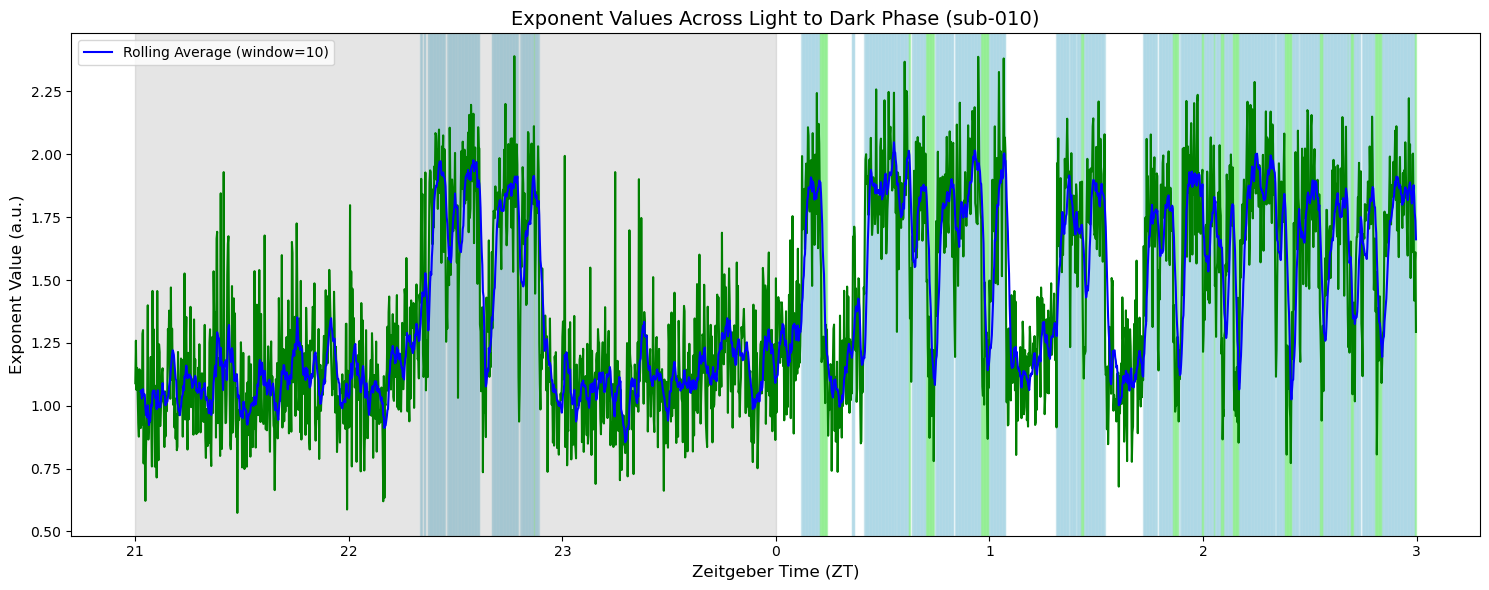

In [11]:
## Plot exponent for dark to light transition with sleep stages

# Find the first occurrence of ZT=0 (start of the day)
zt_zero_start_idx = subset_df[subset_df["ZT"] == 21].index[0]

# Find the second occurrence of ZT=0 (next day)
zt_zero_end_idx = subset_df[subset_df["ZT"] == 3].index[0]

# Filter subset_df to include only data between the first and second occurrence of ZT=0
filtered_subset_df = subset_df.iloc[zt_zero_start_idx:zt_zero_end_idx]

# Shift the ZT values for the second day (start from ZT=0 again)
# Add 24 hours (24) to ZT values for the second part of the day
filtered_subset_df["ZT_shifted"] = filtered_subset_df["ZT"].copy()

# For ZT values from the second day (after 12), shift them by adding 24
filtered_subset_df.loc[filtered_subset_df["ZT"] < 3, "ZT_shifted"] += 24

# Calculate the rolling average of avg_exps with a window size (e.g., 10 data points)
window_size = 10
filtered_subset_df['rolling_avg'] = filtered_subset_df['avg_exps'].rolling(window=window_size).mean()

# Plot the data
plt.figure(figsize=(15, 6))

# Plot the original avg_exps
sns.lineplot(x=filtered_subset_df["ZT_shifted"], y=filtered_subset_df["avg_exps"], color="green")

# Plot the rolling average
sns.lineplot(x=filtered_subset_df["ZT_shifted"], y=filtered_subset_df["rolling_avg"], color="blue", label=f"Rolling Average (window={window_size})")

# Shade the background where sleepStage == 2 (light sleep) or sleepStage == 3 (deep sleep)
for i in range(1, len(filtered_subset_df)):
    # Shade light blue for sleepStage 2 (light sleep)
    if filtered_subset_df["sleepStage"].iloc[i] == 2:
        plt.axvspan(filtered_subset_df["ZT_shifted"].iloc[i-1], filtered_subset_df["ZT_shifted"].iloc[i], color='lightblue', alpha=0.5)  # Light blue
    
    # Shade light green for sleepStage 3 (deep sleep)
    elif filtered_subset_df["sleepStage"].iloc[i] == 3:
        plt.axvspan(filtered_subset_df["ZT_shifted"].iloc[i-1], filtered_subset_df["ZT_shifted"].iloc[i], color='lightgreen', alpha=0.5)  # Light green

# Modify the x-axis ticks and labels
xticks = [21, 22, 23, 24, 25, 26, 27]
xticklabels = ["21", "22", "23", "0", "1", "2", "3"]

plt.xticks(ticks=xticks, labels=xticklabels)

# Add shaded region for ZT=12-24
plt.axvspan(21, 24, color='gray', alpha=0.2)

# Add title and labels
plt.xlabel("Zeitgeber Time (ZT)", fontsize=12)
plt.ylabel("Exponent Value (a.u.)", fontsize=12)
plt.title(f"Exponent Values Across Light to Dark Phase ({sub})", fontsize=14)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f"Z:/volkan/fooof/figures/exponent/{sub}_{extra_info}_exponent_dark_to_light_rollingavg.png")
